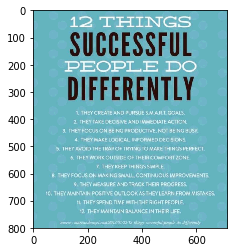

In [23]:
# Adaptive Method For Multi Colored Text Binarization
# Arindam Das (mr.arindam.das@gmail.com), Sandipan Chowdhury (sandipanchowdhury6@gmail.com)
# Some code from https://github.com/jasonlfunk/ocr-text-extraction

import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def image_resize(image, max_size):
    if type(max_size) is list:
        if len(max_size) == 1:
            max_size = [max_size[0], max_size[0]]
    else:
        max_size = [max_size, max_size]
    size = image.shape
    multiplier = min(max_size[0] / size[0], max_size[1] / size[1])
    return cv2.resize(image, (math.floor(size[1] * multiplier), math.floor(size[0] * multiplier)), interpolation = cv2.INTER_AREA)

def image_sharpen_color(image, constant):
    image = np.multiply(image, np.array([1 / constant]))
    image = np.round(image)
    image = np.multiply(image, np.array([constant]))
    image[image > 255] = 255
    image = np.array(image, dtype=np.uint8)
    return image

image_path = 'sample/tips.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image = image_resize(image, 800)
image = image_sharpen_color(image, 10)
image = cv2.blur(image, (2, 2))

image_height = len(image)
image_width = len(image[0])

plt.figure()
plt.imshow(image)

DEBUG = False

Step 1 Done


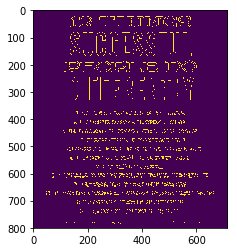

In [24]:
# step 1. preprocessing
# canny edge detection
red, green, blue = cv2.split(image)
        
# Changes on these threshold, affect noise
threshold1 = 250
threshold2 = 250
# Run canny edge detection on each channel
blue_edges = cv2.Canny(blue, threshold1, threshold2)
green_edges = cv2.Canny(green, threshold1, threshold2)
red_edges = cv2.Canny(red, threshold1, threshold2)

# Join edges back into image
edges = blue_edges | green_edges | red_edges

plt.figure()
plt.imshow(edges)

print('Step 1 Done')

if DEBUG:
    cv2.imwrite('edges.png', edges)

In [25]:
if DEBUG:
    processed = edges.copy()
    rejected = edges.copy()

# Find the contours
_, contours, hierarchy = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

class EdgeBox:
    def __init__(self, x, y, w, h, v):
        self.x = x
        self.y = y
        self.width = w
        self.height = h
        self.area = w * h
        self.valid = v and self.first_validation()
        self.descendants_index = []
    
    def get_boundary(self):
        return (self.x, self.y, self.width, self.height)
        
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y and self.width == other.width and self.height == other.height
    
    def contains(self, other):
        if self.width >= other.width and self.height >= other.height \
            and self.x <= other.x and other.x+other.width <= self.x+self.width \
            and self.y <= other.y and other.y+other.height <= self.y+self.height:
            return True
        return False
    
    def first_validation(self):
        # Test it's shape - if it's too oblong or tall it's
        # probably not a real character
        if self.width / self.height < 0.1 or self.width / self.height > 10:
            if DEBUG:
                print("\t Rejected because of shape < 0.1 or > 5: ({}, {}, {}, {}) Ratio = {}"\
                    .format(self.x, self.y, self.width, self.height, self.width / self.height))
            return False

        # check size of the box
        # based on paper below 15 discarded, but to mantain punctuation
        if (self.area < 4):
            if DEBUG:
                print("\t Rejected because of size < 4: ({}, {}, {}, {}) Area = {}"\
                    .format(self.x, self.y, self.width, self.height, self.width / self.height))
            return False

        return True
  
# A quick test to check whether the contour is
# a connected shape
def connected(contour):
    first = contour[0][0]
    last = contour[len(contour) - 1][0]
    return abs(first[0] - last[0]) <= 1 and abs(first[1] - last[1]) <= 1

def descendants_mark(ancestor_index, valid):
    ancestor = edge_box[ancestor_index]
    for child_index in ancestor.descendants_index:
        edge_box[child_index].valid = valid
        
def descendants_count(ancestor_index):
    ancestor = edge_box[ancestor_index]
    area_threshold = 35
    return sum(1 if edge_box[child_index].valid and edge_box[child_index].area >= area_threshold else 0 for child_index in ancestor.descendants_index)
        
def descendants_area(ancestor_index):
    ancestor = edge_box[ancestor_index]
    area_threshold = 35
    result = (0, 0)
    for child_index in ancestor.descendants_index:
        if not edge_box[child_index].valid: continue
        if edge_box[child_index].area >= area_threshold:
            result = (result[0] + edge_box[child_index].area, result[1] + 1)
    return result
  
    
N = len(contours)

# point 1: validation, set EB valid
edge_box = []
for index, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    edge_box.append(EdgeBox(x, y, w, h, connected(contour)))

index_with_area = []
for i in range(N):
    if (edge_box[i].valid):
        index_with_area.append([i, edge_box[i].area])
    
sorted_index_with_area = sorted(index_with_area, key=lambda x : x[1], reverse=True)
M = len(sorted_index_with_area)
for i in range(M):
    idx_i = sorted_index_with_area[i][0]
    if not edge_box[idx_i]: continue
    for j in range(i+1, M):
        idx_j = sorted_index_with_area[j][0]
        if edge_box[idx_i] == edge_box[idx_j]:
            edge_box[idx_j].valid = False
        elif edge_box[idx_i].contains(edge_box[idx_j]):
            edge_box[idx_i].descendants_index.append(idx_j)

def getDebug(xlo, ylo, xhi, yhi, index):
    x, y, w, h = edge_box[index].get_boundary()
    if xlo <= x and x+w <= xhi and ylo <= y and y+h <= yhi:
        return True
    return False

# smaller, accepts bigger text
TEXT_AGAINST_IMAGE = 5
# bigger, accepts bigger region (formerly K parameter)
INNER_AGAINST_OUTER = 12

debug = False

hasChanges = True
while (hasChanges):
    hasChanges = False
    # For each valid edge box
    for index in range(N):
        if not edge_box[index].valid: continue
            
        valid_before = edge_box[index].valid
        
        if DEBUG:
            print("Processing #%d" % index)

        # point 2: If EBi(1 <= i <= N) contains more than three EBs then continue, 
        # otherwise discard all the inner EBs of EBi
        if DEBUG:
            print('descendants', descendants_count(index))
        if (descendants_count(index) + 1 <= 3): # +1 for self EB
            descendants_mark(index, False)
            if DEBUG and debug:
                print(index, "point 2", edge_box[index].descendants_index)
                
        if (valid_before != edge_box[index].valid):
            hasChanges = True

    for index in range(N):
        if not edge_box[index].valid: continue

        valid_before = edge_box[index].valid
        
        # point 3: Calculate the average area of all edge boxes which are present in EBi
        total_area, count_area = descendants_area(index)
        if (edge_box[index].area >= 35 and count_area > 2):
            avg_area = (float)(total_area) / count_area
            
            if DEBUG and debug:
                print(index, "point 3", avg_area * INNER_AGAINST_OUTER, edge_box[index].area, edge_box[index].descendants_index)

            # point 4: If the K times of average area of all inner edge boxes is still less than the area of EBi
            # then discard EB as inner edge boxes have more valid contents, otherwise discard all the inner EBs of EB .
            if (avg_area * INNER_AGAINST_OUTER < edge_box[index].area):
                edge_box[index].valid = False
            else:
                descendants_mark(index, False)
                if DEBUG and debug:
                    print(index, "point 4")

        # point 5: If the 1 ⁄ Kth time of area of input image is less than the area of EB, the EB is large
        #   enough with respect to the entire image, hence must be considered as an invalid edge box.
        if (image_width * image_height / TEXT_AGAINST_IMAGE < edge_box[index].area):
            edge_box[index].valid = False
            if DEBUG and debug:
                print(index, "point 5")
            
        if (valid_before != edge_box[index].valid):
            hasChanges = True
    
valid_index = []
for index in range(N):
    # Check the contour and it's bounding box
    if edge_box[index].valid:
        valid_index.append(index)
        if DEBUG and debug:
            print(index, 'processed', edge_box[index].x, edge_box[index].y, edge_box[index].width, edge_box[index].height, edge_box[index].area)
            cv2.rectangle(processed, (edge_box[index].x, edge_box[index].y), (edge_box[index].x + edge_box[index].width, edge_box[index].y + edge_box[index].height), (100, 100, 100), 1)
            cv2.putText(processed, str(index), (edge_box[index].x, edge_box[index].y - 5), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))
    else:
        if DEBUG and debug:
            print(index, 'rejected', edge_box[index].x, edge_box[index].y, edge_box[index].width, edge_box[index].height, edge_box[index].area)
            cv2.rectangle(rejected, (edge_box[index].x, edge_box[index].y), (edge_box[index].x + edge_box[index].width, edge_box[index].y + edge_box[index].height), (100, 100, 100), 1)
            cv2.putText(rejected, str(index), (edge_box[index].x, edge_box[index].y - 5), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255))

print('Step 2 Done')
            
if DEBUG:
    cv2.imwrite('processed.png', processed)
    cv2.imwrite('rejected.png', rejected)

Step 2 Done


Step 3 Done


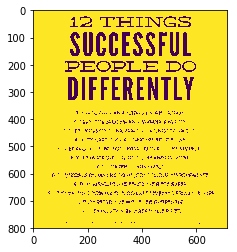

In [26]:
import math

new_image = edges.copy()
new_image.fill(255)

# step 3. Intensity Calculation and Dynamic Thresholding
image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)

def image_lab_pixel(xx, yy):
    global image_lab, image_height, image_width
    if yy < 0 or xx < 0 or yy >= image_height or xx >= image_width:
        return [0, 0, 0]
    pixel = image_lab[yy][xx]
    return pixel

for index in valid_index:
    x_, y_, width, height = edge_box[index].get_boundary()
    twelve_comp = []
    twelve_comp.extend(
        [
            # bottom left corner 3 pixels
            image_lab_pixel(x_ - 1, y_ - 1),
            image_lab_pixel(x_ - 1, y_),
            image_lab_pixel(x_, y_ - 1),

            # bottom right corner 3 pixels
            image_lab_pixel(x_ + width + 1, y_ - 1),
            image_lab_pixel(x_ + width, y_ - 1),
            image_lab_pixel(x_ + width + 1, y_),

            # top left corner 3 pixels
            image_lab_pixel(x_ - 1, y_ + height + 1),
            image_lab_pixel(x_ - 1, y_ + height),
            image_lab_pixel(x_, y_ + height + 1),

            # top right corner 3 pixels
            image_lab_pixel(x_ + width + 1, y_ + height + 1),
            image_lab_pixel(x_ + width, y_ + height + 1),
            image_lab_pixel(x_ + width + 1, y_ + height)
        ])
    
    # background
    B = np.median(twelve_comp, axis=0)
    
    # threshold
    pixels = []
    for h in range(height):
        for w in range(width):
            pixels.append(image_lab_pixel(x_ + w, y_ + h))
    pixel_max = np.max(pixels, axis=0)
    pixel_min = np.min(pixels, axis=0)
    T = sum(pixel_max - pixel_min) / 3
    for h in range(height):
        for w in range(width):
            pixel = image_lab_pixel(x_ + w, y_ + h)
            dE = np.array(pixel) - B
            dE = math.sqrt(sum(dE * dE))
            if dE >= T:
                new_image[y_ + h][x_ + w] = 0

cv2.imwrite('result.png', new_image)

print('Step 3 Done')

plt.figure()
plt.imshow(new_image)